In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

#try:
#    from pycaret.classification import *
#except:
#    print("PyCaret не встановлено. Встановіть: pip install pycaret")
#
import pickle
from tqdm import tqdm

Завантаження даних

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#DATA_PATH = Path('MERGE_Bimodal_Balanced')
DATA_PATH = Path('/content/sample_data')
PROCESSED_FILE = DATA_PATH / 'processed_data_with_all_features.csv'

print("Завантаження даних...")
df = pd.read_csv(PROCESSED_FILE)
print(f"Розмір датасету: {df.shape}")
print(f"\nКолонки: {df.columns.tolist()}")

# Перевірка наявності необхідних колонок
print(f"\nРозподіл по квадрантах:")
print(df['emotion_quadrant'].value_counts())

Mounted at /content/drive
Завантаження даних...
Розмір датасету: (2000, 79)

Колонки: ['Audio_Song', 'Lyric_Song', 'Quadrant', 'AllMusic Id', 'AllMusic Extraction Date', 'Artist', 'Title', 'Relevance', 'Year', 'LowestYear', 'Duration', 'Moods', 'MoodsAll', 'MoodsAllWeights', 'Genres', 'GenreWeights', 'Themes', 'ThemeWeights', 'Styles', 'StyleWeights', 'AppearancesTrackIDs', 'AppearancesAlbumIDs', 'Sample', 'SampleURL', 'ActualYear', 'num_Genres', 'num_MoodsAll', 'Arousal', 'Valence', 'emotion_quadrant', 'lyrics_raw', 'lyrics_length', 'lyrics_processed', 'lyrics_tokens', 'num_tokens', 'duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std', 'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean', 'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std', 'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std', 'mfcc_12_mean', 'mfcc_12_std', 'chroma_mean',

Підготовка даних

In [ ]:

# Вибір features
audio_features = [col for col in df.columns if any(x in col for x in
                  ['mfcc', 'chroma', 'spectral', 'tempo', 'zcr', 'rms',
                   'harmonic', 'percussive', 'mel', 'duration'])]

text_features = [col for col in df.columns if 'lyrics' in col]

print(f"\nАудіо features: {len(audio_features)}")
print(f"Текстові features: {len(text_features)}")

# Підготовка target variable
le = LabelEncoder()
df['emotion_label'] = le.fit_transform(df['emotion_quadrant'])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"\nLabel mapping: {label_mapping}")

# Видалення рядків з NaN в ключових колонках
df_clean = df.dropna(subset=['emotion_quadrant', 'lyrics_processed'])

# Заповнення NaN в аудіо features медіаною
for col in audio_features:
    if col in df_clean.columns:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

print(f"\nРозмір після очищення: {df_clean.shape}")


Аудіо features: 44
Текстові features: 4

Label mapping: {'Q1_Happy_Excited': np.int64(0), 'Q2_Angry_Tense': np.int64(1), 'Q3_Sad_Depressed': np.int64(2), 'Q4_Calm_Relaxed': np.int64(3)}

Розмір після очищення: (2000, 80)


TRAIN/VAL/TEST SPLIT

In [ ]:
# Додайте цей код для діагностики:
print("Колонки в df_clean:")
print(df_clean.columns.tolist())
print("\n")

if train_file.exists():
    print("Колонки в train_df:")
    train_df = pd.read_csv(train_file)
    print(train_df.columns.tolist())

Колонки в df_clean:
['Audio_Song', 'Lyric_Song', 'Quadrant', 'AllMusic Id', 'AllMusic Extraction Date', 'Artist', 'Title', 'Relevance', 'Year', 'LowestYear', 'Duration', 'Moods', 'MoodsAll', 'MoodsAllWeights', 'Genres', 'GenreWeights', 'Themes', 'ThemeWeights', 'Styles', 'StyleWeights', 'AppearancesTrackIDs', 'AppearancesAlbumIDs', 'Sample', 'SampleURL', 'ActualYear', 'num_Genres', 'num_MoodsAll', 'Arousal', 'Valence', 'emotion_quadrant', 'lyrics_raw', 'lyrics_length', 'lyrics_processed', 'lyrics_tokens', 'num_tokens', 'duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std', 'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean', 'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std', 'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std', 'mfcc_12_mean', 'mfcc_12_std', 'chroma_mean', 'chroma_std', 'spectral_centroid_mean', 'spectral_centroid_std', 

NameError: name 'train_file' is not defined

In [ ]:

# Діагностика: перевірка колонок
print("\nДіагностика колонок:")
print(f"Колонки в df_clean: {df_clean.columns.tolist()[:10]}...")  # Перші 10

# Використання існуючих розбиттів якщо є
train_file = DATA_PATH / 'tvt_dataframes' / 'tvt_70_15_15' / 'tvt_70_15_15_train_bimodal_balanced.csv'
val_file = DATA_PATH / 'tvt_dataframes' / 'tvt_70_15_15' / 'tvt_70_15_15_validate_bimodal_balanced.csv'
test_file = DATA_PATH / 'tvt_dataframes' / 'tvt_70_15_15' / 'tvt_70_15_15_test_bimodal_balanced.csv'

if train_file.exists():
    print("\nВикористання існуючих train/val/test splits...")
    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file)
    test_df = pd.read_csv(test_file)

    print(f"Колонки в train_df: {train_df.columns.tolist()}")

    # У train_df колонка 'Song' відповідає 'Audio_Song' в df_clean
    # Спробуємо з Audio_Song або Lyric_Song
    if 'Song' in train_df.columns:
        # Спочатку спробуємо Audio_Song
        train_data = df_clean[df_clean['Audio_Song'].isin(train_df['Song'])].copy()
        val_data = df_clean[df_clean['Audio_Song'].isin(val_df['Song'])].copy()
        test_data = df_clean[df_clean['Audio_Song'].isin(test_df['Song'])].copy()

        print(f"Використовується Audio_Song для merge")
        print(f"Train matches: {len(train_data)}, Val matches: {len(val_data)}, Test matches: {len(test_data)}")

        # Якщо Audio_Song не дало результатів, спробуємо Lyric_Song
        if len(train_data) == 0:
            print("Audio_Song не дав результатів, пробуємо Lyric_Song...")
            train_data = df_clean[df_clean['Lyric_Song'].isin(train_df['Song'])].copy()
            val_data = df_clean[df_clean['Lyric_Song'].isin(val_df['Song'])].copy()
            test_data = df_clean[df_clean['Lyric_Song'].isin(test_df['Song'])].copy()
            print(f"Train matches: {len(train_data)}, Val matches: {len(val_data)}, Test matches: {len(test_data)}")

        # Перевірка чи splits не пусті
        if len(train_data) == 0 or len(val_data) == 0 or len(test_data) == 0:
            print("УВАГА: Один зі splits пустий. Створюємо нові splits...")
            train_data, temp_data = train_test_split(df_clean, test_size=0.3,
                                                     stratify=df_clean['emotion_label'],
                                                     random_state=42)
            val_data, test_data = train_test_split(temp_data, test_size=0.5,
                                                   stratify=temp_data['emotion_label'],
                                                   random_state=42)
    else:
        print("УВАГА: Колонка 'Song' не знайдена. Створюємо нові splits...")
        train_data, temp_data = train_test_split(df_clean, test_size=0.3,
                                                 stratify=df_clean['emotion_label'],
                                                 random_state=42)
        val_data, test_data = train_test_split(temp_data, test_size=0.5,
                                               stratify=temp_data['emotion_label'],
                                               random_state=42)
else:
    print("\nСтворення нових train/val/test splits...")
    train_data, temp_data = train_test_split(df_clean, test_size=0.3,
                                             stratify=df_clean['emotion_label'],
                                             random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5,
                                           stratify=temp_data['emotion_label'],
                                           random_state=42)

print(f"\nTrain size: {len(train_data)} ({len(train_data)/len(df_clean)*100:.1f}%)")
print(f"Val size: {len(val_data)} ({len(val_data)/len(df_clean)*100:.1f}%)")
print(f"Test size: {len(test_data)} ({len(test_data)/len(df_clean)*100:.1f}%)")

# Додаткова перевірка розподілу класів
print("\nРозподіл класів:")
print("Train:", train_data['emotion_quadrant'].value_counts().to_dict())
print("Val:", val_data['emotion_quadrant'].value_counts().to_dict())
print("Test:", test_data['emotion_quadrant'].value_counts().to_dict())


Діагностика колонок:
Колонки в df_clean: ['Audio_Song', 'Lyric_Song', 'Quadrant', 'AllMusic Id', 'AllMusic Extraction Date', 'Artist', 'Title', 'Relevance', 'Year', 'LowestYear']...

Створення нових train/val/test splits...

Train size: 1400 (70.0%)
Val size: 300 (15.0%)
Test size: 300 (15.0%)

Розподіл класів:
Train: {'Q2_Angry_Tense': 350, 'Q3_Sad_Depressed': 350, 'Q1_Happy_Excited': 350, 'Q4_Calm_Relaxed': 350}
Val: {'Q3_Sad_Depressed': 75, 'Q4_Calm_Relaxed': 75, 'Q1_Happy_Excited': 75, 'Q2_Angry_Tense': 75}
Test: {'Q4_Calm_Relaxed': 75, 'Q3_Sad_Depressed': 75, 'Q2_Angry_Tense': 75, 'Q1_Happy_Excited': 75}


🔥 Запуск навчання з MixUp та MLP...
Epoch 1/50 | Train Loss: 1.3703 | Val Loss: 1.2951 | F1: 0.5624
Epoch 2/50 | Train Loss: 1.2666 | Val Loss: 1.0246 | F1: 0.6177
Epoch 3/50 | Train Loss: 1.1319 | Val Loss: 0.8519 | F1: 0.6893
Epoch 4/50 | Train Loss: 1.0191 | Val Loss: 0.7871 | F1: 0.7004
Epoch 5/50 | Train Loss: 0.9427 | Val Loss: 0.7564 | F1: 0.6980
Epoch 6/50 | Train Loss: 0.9145 | Val Loss: 0.7102 | F1: 0.7138
Epoch 7/50 | Train Loss: 0.7853 | Val Loss: 0.6278 | F1: 0.7462
Epoch 8/50 | Train Loss: 0.7141 | Val Loss: 0.5555 | F1: 0.7962
Epoch 9/50 | Train Loss: 0.6519 | Val Loss: 0.4267 | F1: 0.8530
Epoch 10/50 | Train Loss: 0.5968 | Val Loss: 0.2675 | F1: 0.9316
Epoch 11/50 | Train Loss: 0.5403 | Val Loss: 0.2144 | F1: 0.9449
Epoch 12/50 | Train Loss: 0.4031 | Val Loss: 0.1756 | F1: 0.9600
Epoch 13/50 | Train Loss: 0.4217 | Val Loss: 0.1484 | F1: 0.9675
Epoch 14/50 | Train Loss: 0.3942 | Val Loss: 0.1662 | F1: 0.9547
Epoch 15/50 | Train Loss: 0.3578 | Val Loss: 0.1509 | F1: 0.952

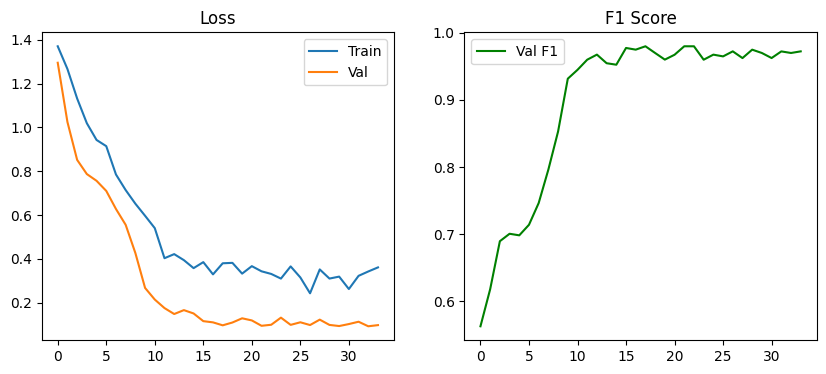

                  precision    recall  f1-score   support

Q1_Happy_Excited       0.98      0.98      0.98       105
  Q2_Angry_Tense       0.96      1.00      0.98       102
Q3_Sad_Depressed       0.99      0.97      0.98        96
 Q4_Calm_Relaxed       0.99      0.97      0.98        97

        accuracy                           0.98       400
       macro avg       0.98      0.98      0.98       400
    weighted avg       0.98      0.98      0.98       400



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

# ============================================================================
# 1. HELPER FUNCTIONS (MIXUP) - СЕКРЕТНА ЗБРОЯ
# ============================================================================

def mixup_data(x_audio, x_ids, x_mask, x_token, y, alpha=0.4):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x_audio.size(0)
    index = torch.randperm(batch_size).to(device)

    # Змішуємо аудіо
    mixed_audio = lam * x_audio + (1 - lam) * x_audio[index, :]
    # Змішуємо текст (в embedding space це неможливо напряму, тому тут трюк:
    # ми просто беремо вхідні дані і будемо рахувати Loss як суміш двох цілей)
    # Для тексту ми не робимо mixup input, ми робимо mixup target.

    y_a, y_b = y, y[index]
    return mixed_audio, x_ids, x_mask, x_token, y_a, y_b, lam, index

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ============================================================================
# 2. СПРОЩЕНА АРХІТЕКТУРА (MLP замість CNN)
# ============================================================================

class AudioMLP(nn.Module):
    """Для 53 числових ознак краще підходить MLP, а не CNN"""
    def __init__(self, input_dim, output_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.5), # Високий Dropout проти перенавчання

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.5),

            nn.Linear(128, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.GELU()
        )
    def forward(self, x):
        return self.net(x)

class RobustModel(nn.Module):
    def __init__(self, num_classes, audio_input_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Заморожуємо майже все, крім останнього шару, щоб не перенавчатись
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.encoder.layer[-1:].parameters(): # Тільки останній шар
            param.requires_grad = True

        self.audio_encoder = AudioMLP(audio_input_dim, output_dim=128)

        # Attention Fusion
        self.fusion_dim = 128
        self.text_proj = nn.Linear(768, self.fusion_dim)
        self.audio_proj = nn.Linear(128, self.fusion_dim)
        self.attention = nn.Linear(self.fusion_dim * 2, 1)

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.fusion_dim, num_classes)
        )

    def forward(self, ids, mask, token_type_ids, audio_features):
        # Text
        bert_out = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        text_emb = bert_out.pooler_output # [Batch, 768]
        text_proj = torch.tanh(self.text_proj(text_emb))

        # Audio
        audio_proj = torch.tanh(self.audio_encoder(audio_features))

        # Attention
        concat = torch.cat([text_proj, audio_proj], dim=1)
        weights = torch.sigmoid(self.attention(concat))

        # Weighted sum
        fused = weights * text_proj + (1 - weights) * audio_proj

        return self.classifier(fused)

# ============================================================================
# 3. НАЛАШТУВАННЯ ТА ЗАПУСК
# ============================================================================

model = RobustModel(num_classes=len(le.classes_), audio_input_dim=len(audio_feature_cols))
model.to(device)

# Обчислення ваг класів
y_train_indices = train_df['label_encoded'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_indices), y=y_train_indices)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Параметри навчання
EPOCHS = 50 # MixUp потребує більше епох
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=0.05) # Сильніший weight decay
scheduler = OneCycleLR(optimizer, max_lr=5e-4, steps_per_epoch=len(training_loader), epochs=EPOCHS)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Історія
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_f1 = 0
best_model_wts = copy.deepcopy(model.state_dict())
patience = 12
counter = 0

print("🔥 Запуск навчання з MixUp та MLP...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for data in training_loader:
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        audio_features = data['audio_features'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()

        # --- MIXUP LOGIC START ---
        # З ймовірністю 50% застосовуємо MixUp
        if np.random.random() > 0.5:
            mixed_audio, _, _, _, y_a, y_b, lam, idx = mixup_data(audio_features, ids, mask, token_type_ids, targets)

            # Важливо: Для тексту ми не можемо зробити mixup input id,
            # тому ми просто подаємо оригінальний текст, але "змішуємо" його batch order
            # Це компроміс. Ми кажемо моделі: "ось це аудіо (змішане) + цей текст (оригінал)"
            # відповідає міксу лейблів.

            # Трюк: просто використовуємо оригінальні ID, але Loss рахуємо хитро
            outputs = model(ids, mask, token_type_ids, mixed_audio)

            # MixUp Loss: комбінація втрат для оригінального порядку та перемішаного
            loss = mixup_criterion(loss_fn, outputs, y_a, y_b, lam)
        else:
            # Звичайне навчання
            outputs = model(ids, mask, token_type_ids, audio_features)
            loss = loss_fn(outputs, targets)
        # --- MIXUP LOGIC END ---

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for data in testing_loader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            audio_features = data['audio_features'].to(device)
            targets = data['targets'].to(device)

            outputs = model(ids, mask, token_type_ids, audio_features)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            fin_targets.extend(targets.cpu().tolist())
            fin_outputs.extend(predicted.cpu().tolist())

    avg_train_loss = total_loss / len(training_loader)
    avg_val_loss = val_loss / len(testing_loader)
    val_f1 = f1_score(fin_targets, fin_outputs, average='weighted')
    val_acc = accuracy_score(fin_targets, fin_outputs)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_f1'].append(val_f1)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping.")
            break

print(f"\n🏆 Best Weighted F1: {best_f1:.4f}")
model.load_state_dict(best_model_wts)

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='Val F1', color='green')
plt.title('F1 Score')
plt.legend()
plt.show()

# Final Report
model.eval()
fin_targets = []
fin_outputs = []
with torch.no_grad():
    for data in testing_loader:
        outputs = model(data['ids'].to(device), data['mask'].to(device),
                       data['token_type_ids'].to(device), data['audio_features'].to(device))
        _, predicted = torch.max(outputs, 1)
        fin_targets.extend(data['targets'].tolist())
        fin_outputs.extend(predicted.tolist())

print(classification_report(fin_targets, fin_outputs, target_names=le.classes_))

Використовується пристрій: cuda
🚀 Починаємо навчання...
Epoch 1/40 | Train Loss: 1.4066 | Val Loss: 1.3907 | Acc: 0.2850 | F1: 0.2022
Epoch 2/40 | Train Loss: 1.3893 | Val Loss: 1.3669 | Acc: 0.3275 | F1: 0.2597
Epoch 3/40 | Train Loss: 1.3686 | Val Loss: 1.3030 | Acc: 0.3975 | F1: 0.3444
Epoch 4/40 | Train Loss: 1.2648 | Val Loss: 1.1232 | Acc: 0.5525 | F1: 0.5088
Epoch 5/40 | Train Loss: 1.1447 | Val Loss: 0.9657 | Acc: 0.5875 | F1: 0.5589
Epoch 6/40 | Train Loss: 1.0850 | Val Loss: 0.8464 | Acc: 0.6950 | F1: 0.6896
Epoch 7/40 | Train Loss: 1.0685 | Val Loss: 0.8163 | Acc: 0.6950 | F1: 0.6896
Epoch 8/40 | Train Loss: 0.9498 | Val Loss: 0.7859 | Acc: 0.6875 | F1: 0.6820
Epoch 9/40 | Train Loss: 0.9342 | Val Loss: 0.7196 | Acc: 0.7275 | F1: 0.7244
Epoch 10/40 | Train Loss: 0.8343 | Val Loss: 0.7539 | Acc: 0.6925 | F1: 0.6887
Epoch 11/40 | Train Loss: 0.8188 | Val Loss: 0.6945 | Acc: 0.7275 | F1: 0.7232
Epoch 12/40 | Train Loss: 0.7793 | Val Loss: 0.6576 | Acc: 0.7475 | F1: 0.7443
Epoch

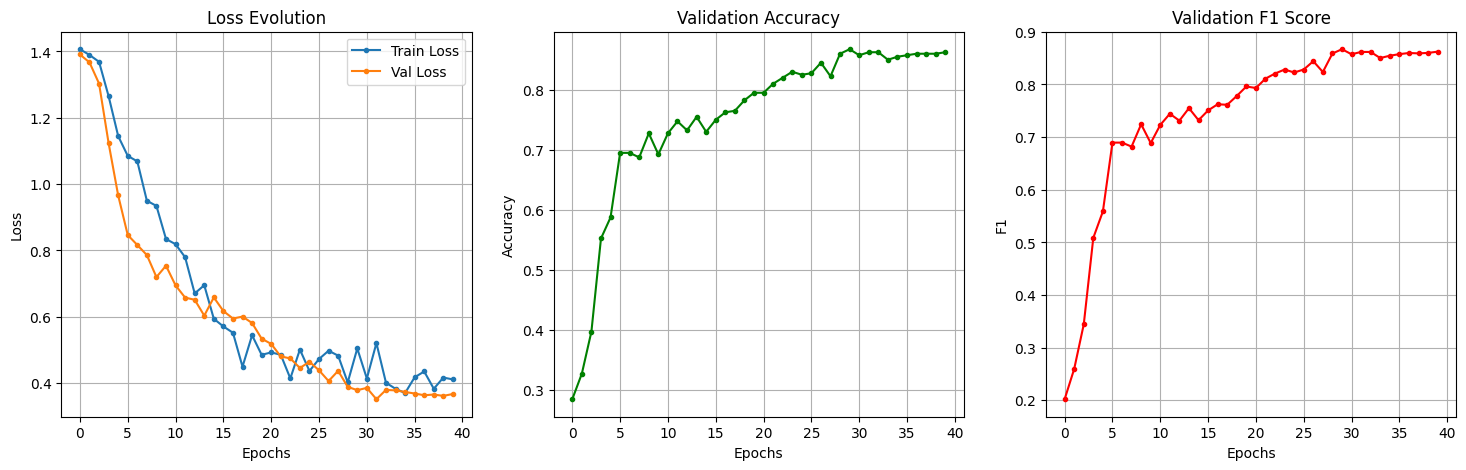


📊 DETAILED CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

Q1_Happy_Excited       0.93      0.86      0.89       105
  Q2_Angry_Tense       0.91      0.95      0.93       102
Q3_Sad_Depressed       0.80      0.90      0.84        96
 Q4_Calm_Relaxed       0.84      0.76      0.80        97

        accuracy                           0.87       400
       macro avg       0.87      0.87      0.87       400
    weighted avg       0.87      0.87      0.87       400



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
import seaborn as sns

# ============================================================================
# 1. КОНФІГУРАЦІЯ
# ============================================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Використовується пристрій: {device}")

# Параметри
BATCH_SIZE = 16
MAX_LEN = 128
EPOCHS = 40  # Достатньо для MixUp
LEARNING_RATE = 5e-5 # Трохи менший для стабільності BERT

# Переконайтеся, що tokenizer ініціалізовано
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# ============================================================================
# 2. ПІДГОТОВКА ДАНИХ (DATASET & MIXUP)
# ============================================================================

class MultimodalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, text_col, audio_cols):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe[text_col].astype(str)
        self.targets = dataframe['label_encoded'].values
        self.audio = dataframe[audio_cols].values
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text, None, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', return_token_type_ids=True, truncation=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            'audio_features': torch.tensor(self.audio[index], dtype=torch.float),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

# Функція MixUp (змішує аудіо та лейбли)
def mixup_data(x_audio, x_ids, x_mask, x_token, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x_audio.size(0)
    index = torch.randperm(batch_size).to(device)

    # Змішуємо аудіо вектори
    mixed_audio = lam * x_audio + (1 - lam) * x_audio[index, :]

    # Текст не змішуємо фізично, але рахуємо Loss для двох цілей
    y_a, y_b = y, y[index]
    return mixed_audio, x_ids, x_mask, x_token, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Створення лоадерів (важливо: використовуйте train_df/test_df з GroupShuffleSplit!)
training_set = MultimodalDataset(train_df, tokenizer, MAX_LEN, text_col, audio_feature_cols)
testing_set = MultimodalDataset(test_df, tokenizer, MAX_LEN, text_col, audio_feature_cols)

training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
testing_loader = DataLoader(testing_set, batch_size=BATCH_SIZE, shuffle=False)

# ============================================================================
# 3. АРХІТЕКТУРА (AUDIO MLP + BERT)
# ============================================================================

class AudioMLP(nn.Module):
    def __init__(self, input_dim, output_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.4),

            nn.Linear(128, output_dim), # [Batch, 128]
            nn.BatchNorm1d(output_dim),
            nn.GELU()
        )
    def forward(self, x):
        return self.net(x)

class CombinedModel(nn.Module):
    def __init__(self, num_classes, audio_input_dim):
        super().__init__()
        # 1. BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Заморожуємо все, крім останніх 2 шарів
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.encoder.layer[-2:].parameters():
            param.requires_grad = True

        # 2. Audio MLP
        self.audio_encoder = AudioMLP(audio_input_dim, output_dim=128)

        # 3. Fusion & Classifier
        # BERT output (768) + Audio output (128)
        self.fusion_layer = nn.Linear(768 + 128, 256)
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, ids, mask, token_type_ids, audio_features):
        # Text path
        bert_out = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        text_emb = bert_out.pooler_output # [Batch, 768]

        # Audio path
        audio_emb = self.audio_encoder(audio_features) # [Batch, 128]

        # Concatenation
        combined = torch.cat((text_emb, audio_emb), dim=1) # [Batch, 896]

        # Classification
        x = torch.relu(self.fusion_layer(combined))
        x = self.dropout(x)
        output = self.classifier(x)
        return output

# ============================================================================
# 4. НАЛАШТУВАННЯ НАВЧАННЯ
# ============================================================================

model = CombinedModel(num_classes=len(le.classes_), audio_input_dim=len(audio_feature_cols))
model.to(device)

# Ваги класів
y_train_indices = train_df['label_encoded'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_indices), y=y_train_indices)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(training_loader), epochs=EPOCHS)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# ============================================================================
# 5. ЦИКЛ НАВЧАННЯ (TRAINING LOOP)
# ============================================================================

history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_f1 = 0
best_model_wts = copy.deepcopy(model.state_dict())
patience = 10
counter = 0

print("🚀 Починаємо навчання...")

for epoch in range(EPOCHS):
    # --- TRAIN ---
    model.train()
    total_loss = 0

    for data in training_loader:
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        audio_features = data['audio_features'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()

        # MixUp з ймовірністю 50%
        if np.random.random() > 0.5:
            mixed_audio, _, _, _, y_a, y_b, lam = mixup_data(audio_features, ids, mask, token_type_ids, targets)
            outputs = model(ids, mask, token_type_ids, mixed_audio)
            loss = mixup_criterion(loss_fn, outputs, y_a, y_b, lam)
        else:
            outputs = model(ids, mask, token_type_ids, audio_features)
            loss = loss_fn(outputs, targets)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    # --- VALIDATION ---
    model.eval()
    val_loss = 0
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for data in testing_loader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            audio_features = data['audio_features'].to(device)
            targets = data['targets'].to(device)

            outputs = model(ids, mask, token_type_ids, audio_features)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            fin_targets.extend(targets.cpu().tolist())
            fin_outputs.extend(predicted.cpu().tolist())

    # Метрики
    avg_train_loss = total_loss / len(training_loader)
    avg_val_loss = val_loss / len(testing_loader)
    val_acc = accuracy_score(fin_targets, fin_outputs)
    val_f1 = f1_score(fin_targets, fin_outputs, average='weighted')

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    # Early Stopping
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
        torch.save(model.state_dict(), 'best_combined_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("🛑 Early Stopping!")
            break

# ============================================================================
# 6. ГРАФІКИ ТА РЕЗУЛЬТАТИ
# ============================================================================

model.load_state_dict(best_model_wts)
print(f"\n🏆 Найкращий Weighted F1: {best_f1:.4f}")

plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='.')
plt.plot(history['val_loss'], label='Val Loss', marker='.')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history['val_acc'], label='Val Accuracy', color='green', marker='.')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# F1 Score
plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], label='Val F1 Score', color='red', marker='.')
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.grid(True)

plt.show()

# Фінальний звіт
model.eval()
fin_targets = []
fin_outputs = []
with torch.no_grad():
    for data in testing_loader:
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        audio_features = data['audio_features'].to(device)
        targets = data['targets'].to(device)

        outputs = model(ids, mask, token_type_ids, audio_features)
        _, predicted = torch.max(outputs, 1)

        fin_targets.extend(targets.cpu().tolist())
        fin_outputs.extend(predicted.cpu().tolist())

print("\n📊 DETAILED CLASSIFICATION REPORT:")
print(classification_report(fin_targets, fin_outputs, target_names=le.classes_))

Mounted at /content/drive
⏳ Завантаження даних з: /content/sample_data/processed_data_with_all_features.csv
✅ Дані розбито по піснях (щоб уникнути витоку).
Train size: 1600 | Test size: 400


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

🚀 Запуск навчання Text-Only моделі...
Epoch 1/15 | Train Loss: 1.4163 | Val Loss: 1.3867 | F1: 0.2169
Epoch 2/15 | Train Loss: 1.3849 | Val Loss: 1.3256 | F1: 0.5104
Epoch 3/15 | Train Loss: 1.2216 | Val Loss: 1.0157 | F1: 0.6388
Epoch 4/15 | Train Loss: 0.9412 | Val Loss: 0.8449 | F1: 0.6616
Epoch 5/15 | Train Loss: 0.7832 | Val Loss: 0.7945 | F1: 0.6645
Epoch 6/15 | Train Loss: 0.6866 | Val Loss: 0.7754 | F1: 0.7039
Epoch 7/15 | Train Loss: 0.6069 | Val Loss: 0.7927 | F1: 0.6841
Epoch 8/15 | Train Loss: 0.5421 | Val Loss: 0.7926 | F1: 0.6912
Epoch 9/15 | Train Loss: 0.4835 | Val Loss: 0.8014 | F1: 0.7009
Epoch 10/15 | Train Loss: 0.4394 | Val Loss: 0.8086 | F1: 0.7087
Epoch 11/15 | Train Loss: 0.4011 | Val Loss: 0.8221 | F1: 0.7044
Epoch 12/15 | Train Loss: 0.3624 | Val Loss: 0.8351 | F1: 0.7061
Epoch 13/15 | Train Loss: 0.3402 | Val Loss: 0.8402 | F1: 0.7073
Epoch 14/15 | Train Loss: 0.3339 | Val Loss: 0.8359 | F1: 0.7079
Epoch 15/15 | Train Loss: 0.3321 | Val Loss: 0.8360 | F1: 0.7

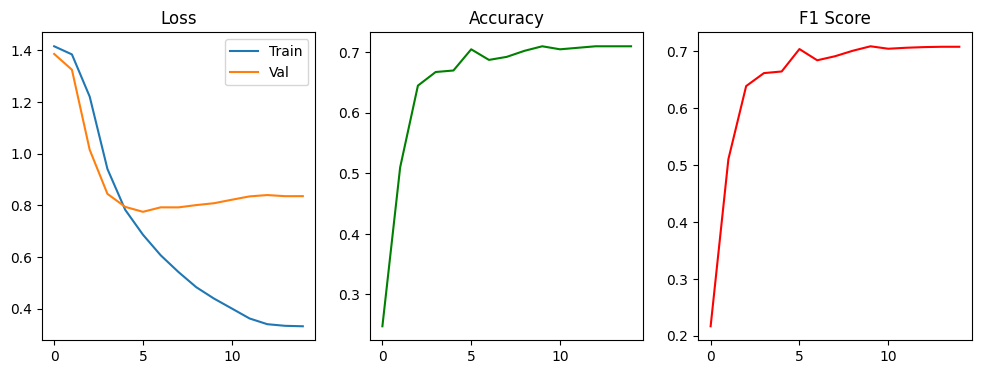

                  precision    recall  f1-score   support

Q1_Happy_Excited       0.69      0.66      0.67       105
  Q2_Angry_Tense       0.82      0.87      0.85       102
Q3_Sad_Depressed       0.69      0.64      0.66        96
 Q4_Calm_Relaxed       0.63      0.67      0.65        97

        accuracy                           0.71       400
       macro avg       0.71      0.71      0.71       400
    weighted avg       0.71      0.71      0.71       400



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
from pathlib import Path
from google.colab import drive

# ============================================================================
# 1. ЗАВАНТАЖЕННЯ ТА ПІДГОТОВКА ДАНИХ (З НУЛЯ)
# ============================================================================

# Монтуємо диск
drive.mount('/content/drive', force_remount=True)

# Конфігурація
DATA_PATH = Path('/content/sample_data')
FILE_NAME = 'processed_data_with_all_features.csv'
FULL_PATH = DATA_PATH / FILE_NAME
BATCH_SIZE = 16
MAX_LEN = 128
EPOCHS = 15 # Для тексту достатньо менше
LEARNING_RATE = 2e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"⏳ Завантаження даних з: {FULL_PATH}")
df = pd.read_csv(FULL_PATH)

# Очистка і підготовка
text_col = 'lyrics_raw'
target_col = 'emotion_quadrant'
if text_col not in df.columns: text_col = 'lyrics' # Страховка

# Кодування лейблів
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df[target_col])

# --- ВАЖЛИВО: ПРАВИЛЬНЕ РОЗБИТТЯ (Group Split) ---
# Використовуємо 'Audio_Song' або іншу колонку, яка ідентифікує пісню
group_col = 'Audio_Song'
if group_col not in df.columns: group_col = 'filename' # Страховка

splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idxs, test_idxs = next(splitter.split(df, groups=df[group_col]))

train_df = df.iloc[train_idxs].reset_index(drop=True)
test_df = df.iloc[test_idxs].reset_index(drop=True)

print(f"✅ Дані розбито по піснях (щоб уникнути витоку).")
print(f"Train size: {len(train_df)} | Test size: {len(test_df)}")

# ============================================================================
# 2. DATASET & DATALOADERS
# ============================================================================

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, text_col):
        self.tokenizer = tokenizer
        self.text = dataframe[text_col].astype(str)
        self.targets = dataframe['label_encoded'].values
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split()) # Видалення зайвих пробілів

        inputs = self.tokenizer.encode_plus(
            text, None, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', return_token_type_ids=True, truncation=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

training_set = TextDataset(train_df, tokenizer, MAX_LEN, text_col)
testing_set = TextDataset(test_df, tokenizer, MAX_LEN, text_col)

training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
testing_loader = DataLoader(testing_set, batch_size=BATCH_SIZE, shuffle=False)

# ============================================================================
# 3. МОДЕЛЬ (TEXT ONLY BERT)
# ============================================================================

class TextBERT(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Заморожуємо більшість шарів для стабільності
        for param in self.bert.parameters():
            param.requires_grad = False
        # Розморожуємо 2 останні шари Encoder'а
        for param in self.bert.encoder.layer[-2:].parameters():
            param.requires_grad = True

        self.drop = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, ids, mask, token_type_ids):
        output = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        x = self.drop(output.pooler_output)
        return self.classifier(x)

model = TextBERT(num_classes=len(le.classes_))
model.to(device)

# ============================================================================
# 4. НАВЧАННЯ
# ============================================================================

# Ваги класів
y_train = train_df['label_encoded'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(training_loader), epochs=EPOCHS)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_f1 = 0
best_model_wts = copy.deepcopy(model.state_dict())

print("🚀 Запуск навчання Text-Only моделі...")

for epoch in range(EPOCHS):
    # Train
    model.train()
    total_loss = 0
    for data in training_loader:
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    # Val
    model.eval()
    val_loss = 0
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for data in testing_loader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            fin_targets.extend(targets.cpu().tolist())
            fin_outputs.extend(predicted.cpu().tolist())

    avg_train_loss = total_loss / len(training_loader)
    avg_val_loss = val_loss / len(testing_loader)
    val_f1 = f1_score(fin_targets, fin_outputs, average='weighted')
    val_acc = accuracy_score(fin_targets, fin_outputs)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_f1'].append(val_f1)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())

print(f"\n🏆 Text-Only Best F1: {best_f1:.4f}")

# ============================================================================
# 5. ГРАФІКИ
# ============================================================================
model.load_state_dict(best_model_wts)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['val_acc'], color='green', label='Accuracy')
plt.title('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], color='red', label='F1 Score')
plt.title('F1 Score')
plt.show()

# Звіт
model.eval()
fin_targets = []
fin_outputs = []
with torch.no_grad():
    for data in testing_loader:
        outputs = model(data['ids'].to(device), data['mask'].to(device), data['token_type_ids'].to(device))
        _, predicted = torch.max(outputs, 1)
        fin_targets.extend(data['targets'].tolist())
        fin_outputs.extend(predicted.tolist())

print(classification_report(fin_targets, fin_outputs, target_names=le.classes_))